In [40]:
import xarray as xr
import matplotlib.pyplot as plt
from xgcm import Grid

In [3]:
exp= ["CM4", "ESM4"]

path = {"CM4": "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp",
       "ESM4": "/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/pp"}

Text(0.5, 1.0, 'SO-integrated windstress, N')

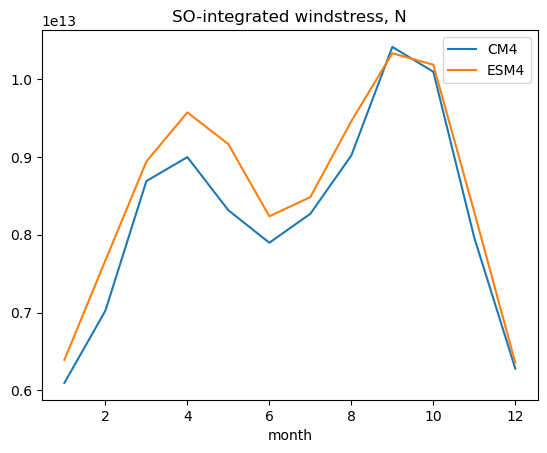

In [160]:
for i in exp:
    ds_grid = xr.open_dataset(f"{path[i]}/ocean_monthly/ocean_monthly.static.nc")
    ds = xr.open_mfdataset(f"{path[i]}/ocean_monthly/ts/monthly/5yr/*tau*", use_cftime=True)

    area_SO = ds_grid.areacello_cu.where((ds_grid.geolat_u < -40) & (ds_grid.wet_u ==1))
    SO_tau = (area_SO * ds.tauuo).sum(dim=["xq", "yh"])

    SO_tau.groupby(SO_tau.time.dt.month).mean().plot(label=i)
plt.legend()
plt.title("SO-integrated windstress, N")

## Location of zero wind stress curl in CM4 and ESM4

Note that the output is saved in non-symmetric form

In [41]:
ds_grid.xh, ds_grid.xq

(<xarray.DataArray 'xh' (xh: 720)>
 array([-299.75, -299.25, -298.75, ...,   58.75,   59.25,   59.75])
 Coordinates:
   * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
 Attributes:
     units:      degrees_east
     long_name:  h point nominal longitude
     axis:       X,
 <xarray.DataArray 'xq' (xq: 720)>
 array([-299.5, -299. , -298.5, ...,   59. ,   59.5,   60. ])
 Coordinates:
   * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
 Attributes:
     units:      degrees_east
     long_name:  q point nominal longitude
     axis:       X)

In [42]:
grid = Grid(ds_grid, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In [44]:
tau_curl = ( - grid.diff(ds.tauuo * ds.dxCu, 'Y', boundary="fill")
             + grid.diff(ds.tauvo * ds.dyCv, 'X', boundary="fill")) / ds_grid.areacello_bu

In [161]:
tau_curl_x = ( - grid.diff(ds.tauuo * ds_grid.dxCu, 'Y', boundary="fill"))

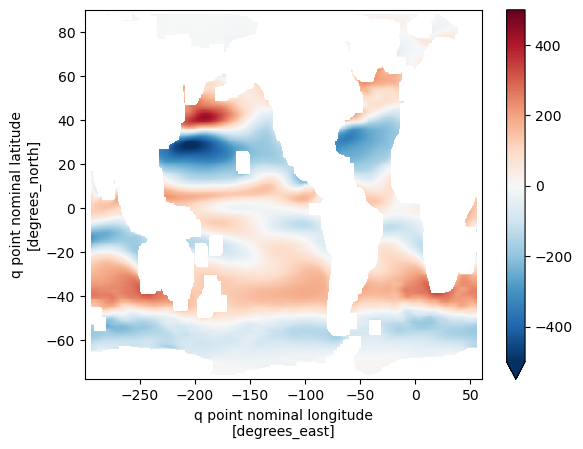

In [172]:
tau_curl_x[::12,:,:].mean(dim="time").rolling({'xq' :20, 'yq':20}, center=True).mean().plot(vmin=-500, vmax=500, cmap="RdBu_r")

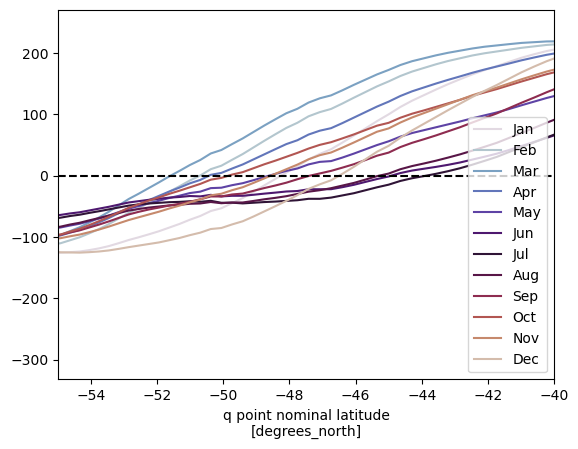

In [174]:
for i in range(12):
    x = tau_curl_x[i::12,:,:].mean(dim="time").rolling({'xq' :20, 'yq':20}, center=True).mean()
    x.mean(["xq"]).plot(color=cmap(i/13), label=month[i])

plt.plot([-55, -40], [0, 0], 'k--')
plt.xlim([-55, -40])
plt.legend()

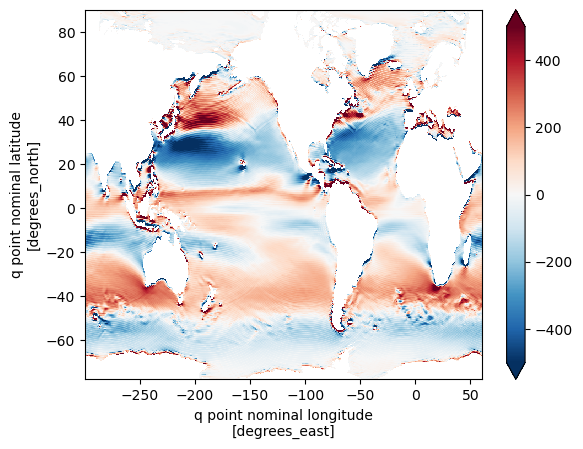

In [163]:
tau_curl_x[::12,:,:].mean(dim="time").plot(vmin=-500, vmax=500, cmap="RdBu_r")

In [61]:
ds_tau = tau_curl.to_dataset(name="tau_curl")
ds_tau

<xarray.Dataset>
Dimensions:   (xq: 720, yq: 576, time: 1200)
Coordinates:
  * xq        (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
  * yq        (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
Dimensions without coordinates: time
Data variables:
    tau_curl  (time, yq, xq) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>

In [67]:
ds_tau = ds_tau.assign_coords({'geolon': ds_grid['geolon_c'],
                       'geolat': ds_grid['geolat_c']})


In [132]:
cmap = plt.get_cmap("twilight", 13)
month=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

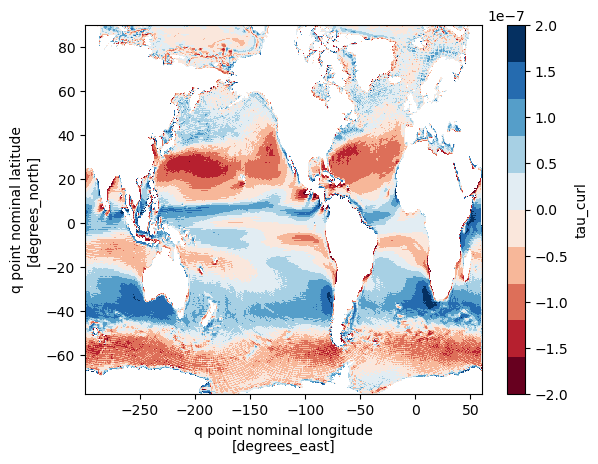

In [155]:
x = ds_tau.tau_curl[::12,:,:]
x_masked = x.where((x < 2e-7) & (x>-2e-7))
x_masked.mean(dim="time").plot(cmap=plt.get_cmap('RdBu',10), extend="neither", vmin=-2e-7, vmax=2e-7)

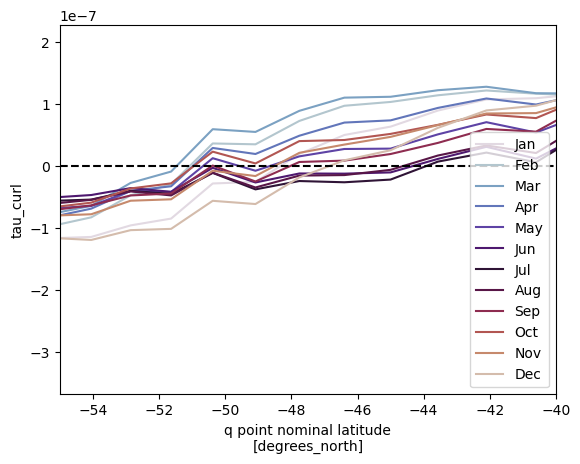

In [154]:
for i in range(12):
    x = ds_tau.tau_curl[i::12,::4,::4]
    x_masked = x.where((x < 5e-7) & (x>-5e-7))
    x.mean(["time","xq"]).plot(color=cmap(i/13), label=month[i])

plt.plot([-55, -40], [0, 0], 'k--')
plt.xlim([-55, -40])
plt.legend()

1220 -50.139927640725396
1239 -51.39348432570162
1357 -52.112731596048704
1532 -51.3061347722304
1812 -51.655437166529914
1437 -51.59343756797298
1128 -53.34490575152343
564 -49.78855390921499
999 -54.92882285948999
1499 -52.925718192894884
1573 -50.58491291486995
1177 -48.76602843310753


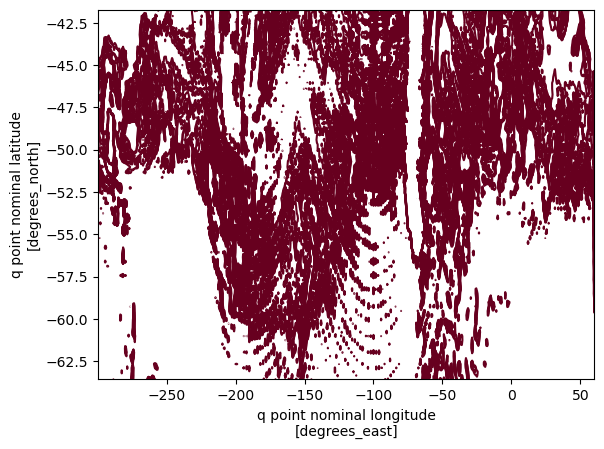

In [148]:
tau_0 = []

for i in range(12):
    x = ds_tau.tau_curl[i::12,:,:]
    x_masked = x.where((x < 5e-7) & (x>-5e-7))
    contour = x[:,75:150,:].mean("time").plot.contour(levels=[0])
    tau_0.append(contour.collections[0].get_paths())

for j in range(12):
    path_length = [len(i) for i in tau_0[j]]
    idx = path_length.index(max(path_length))
    lat = tau_0[j][idx].vertices[:,1].mean()
    print(max(path_length), lat)

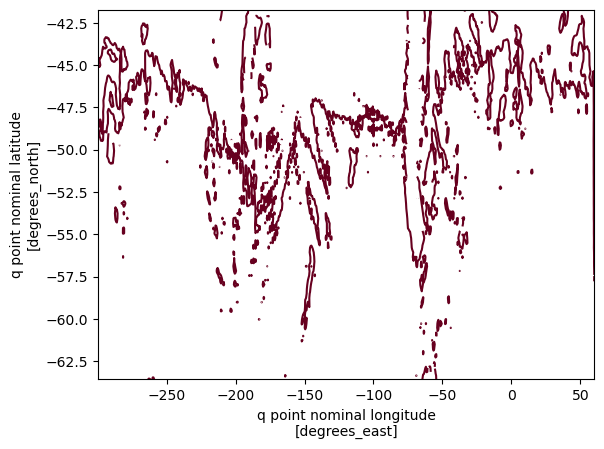

In [149]:
x[:,75:150,:].mean("time").plot.contour(levels=[0])